# Decoding Sherlock Holmes: A Comparative Analysis of BERT Models’ Performance
#### Team 2 - Ria Patel, Devanshi Patel, Sai Dasari, Seoyoung Amy An, and Jihun Kim

This notebook compares the performance between different versions of **BERT**-based (Bidirectional Encoder Representations from Transformers) language models on question-answering tasks about stories written by Sir Arthur Conan Doyle. We perform one-shot testing on BERT, RoBERTa, and SpanBERT models to get a baseline understanding of how all three models work and why they differ. We ask questions of varying difficulty levels to find the extent in which these models can comprehend and answer them. We observed that the RoBERTa models were the best models in comparison to BERT and SpanBERT. To gauge performance, we eyeballed the answers and determined them correct/incorrect via a test bank of answers. These graphs are generated via another script in this project's zip file.

### Observations
BERT took the longest amount of time to generate answers for each question. They were also the worst answers, often giving repetitive and very short answers that are nonsensical. Same applies with SpanBERT, except that it seemed to generate long nonsensical answers. RoBERTa gives the best succinct answers.

### Metadata

#### Processed Books
1. A Study in Scarlet
2. Hound of Baskerville
3. Valley of Fear

#### Models
- BERT:
    - bert-base-uncased
    - bert-base-cased
- SpanBERT:
    - spanbert-base-cased
    - spanbert-large-uncased
- RoBERTa:
    - oberta-base-squad2
    - roberta-large-squad2
    - tinyroberta-squad2
    - roberta-base-squad2-distilled


### Questions
1. Who supports Sherlock Holmes on the investigation?
2. Who is the victim?
3. Who killed the victim?
4. Where does the murder take place?
5. What is the murder weapon?",
6. When does Sherlock Holmes begin to unravel the details that lead to solving the murder?",
7. How does Sherlock find the murderer?",
8. What is the motive for the murder?",
9. What is the evidence that led Sherlock Holmes to the murderer?",
10. What is the plot twist of the story?",




In [ ]:
!pip --quiet install requests transformers torch nltk

In [ ]:
import requests
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from concurrent.futures import ThreadPoolExecutor
import re
import nltk
import time
import concurrent.futures
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Hound of Baskervilles
hound = 'https://www.gutenberg.org/cache/epub/2852/pg2852.txt'

# Valley of Fear
valley = 'https://www.gutenberg.org/cache/epub/3289/pg3289.txt'

# A Study in Scarlet
scarlet = 'https://www.gutenberg.org/cache/epub/244/pg244.txt'


In [ ]:
def process_text(url):
    # Load the book text
    response = requests.get(url)
    book_text = response.text

    # Preprocess the text: Remove headers, split into chapters, clean text
    title = (re.search(r"\*\*\* START OF THE PROJECT GUTENBERG EBOOK (.*?) \*\*\*", response.text)).group(1).strip()
    start_marker = r"*** START OF THE PROJECT GUTENBERG EBOOK {} ***".format(title)
    end_marker = r"*** END OF THE PROJECT GUTENBERG EBOOK {} ***".format(title)

    start_index = book_text.find(start_marker)
    end_index = book_text.find(end_marker)
    clean_text = book_text[start_index + len(start_marker):end_index].strip()
    clean_text = clean_text.replace('\r\n', ' ').replace('\n', ' ')
    clean_text = ' '.join(clean_text.split())

    return clean_text

# Split text into  chunks
def split_text_into_chunks(text, chunk_size=512):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    chunks = []
    while len(filtered_words) > 0:
        chunk = filtered_words[:chunk_size]
        chunks.append(' '.join(chunk))
        filtered_words = filtered_words[chunk_size:]

    return chunks

# Ask questions and evaluate answers
def ask_question(model_name, question, context, qa_pipelines):
    qa_pipeline = qa_pipelines[model_name]
    result = qa_pipeline(question=question, context=context)
    return result['answer']

def process_questions_in_parallel(questions, clean_text, qa_pipelines):
    chunks = split_text_into_chunks(clean_text)
    answers = {}
    times = {}

    for i, question in enumerate(questions):
        times[f"q{i}"] = {}
        answers[f"q{i}"] = {}

        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {model_name: executor.submit(process_model, model_name, question, chunks, qa_pipelines) for model_name in model_names}

            for model_name, future in futures.items():
                start_time = time.time()
                answer = future.result()
                run_time = time.time() - start_time

                # answers[model_name] = answer
                answers[f"q{i}"][model_name] = answer
                times[f"q{i}"][model_name] = run_time

    return answers, times

# Process a single model and aggregate answers from chunks
def process_model(model_name, question, chunks, qa_pipelines):
    model_answers = []
    for chunk in chunks:
        answer = ask_question(model_name, question, chunk, qa_pipelines)
        model_answers.append(answer)
    # Combine the answers (choose the most frequent answer or best match)
    return max(set(model_answers), key=model_answers.count)

In [ ]:
# Initialize the question-answering pipeline for better models
model_names = [
  "bert-base-uncased",
  "bert-large-cased",
  "deepset/roberta-base-squad2",
  "deepset/roberta-large-squad2",
  "deepset/tinyroberta-squad2",
  "deepset/roberta-base-squad2-distilled",
  "SpanBERT/spanbert-base-cased",
  "SpanBERT/spanbert-large-cased",
]

# Questions related to the plot of the book
questions = [
  "Who supports Sherlock Holmes on the investigation?",
  "Who is the victim?",
  "Who killed the victim?",
  "Where does the murder take place?",
  "What is the murder weapon?",
  "When does Sherlock Holmes begin to unravel the details that lead to solving the murder?",
  "How does Sherlock find the murderer?",
  "What is the motive for the murder?",
  "What is the evidence that led Sherlock Holmes to the murderer?",
  "What is the plot twist of the story?",
]

In [ ]:
# Initialize the question-answering pipeline for each model
qa_pipelines = {}
for model_name in model_names:
    # Load model and move it to the GPU if available
    qa_pipelines[model_name] = pipeline("question-answering", model=model_name, device=0 if device == "cuda" else -1)
    # pipeline: deal with question and answering for bert

In [ ]:
PATH = '/content/drive/Shareddrives/Team 2 - COSC524/Final Project/Final Code and Results/CSV Files/'

clean_hound = process_text(hound)
hound_responses, hound_run_times = process_questions_in_parallel(questions, clean_hound, qa_pipelines)
pd.DataFrame(hound_run_times).to_csv(f'{PATH}/hound_run_times.csv')
pd.DataFrame(hound_responses).to_csv(f'{PATH}/hound_responses.csv')

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
clean_scarlet = process_text(scarlet)
scarlet_responses, scarlet_run_times = process_questions_in_parallel(questions, clean_scarlet, qa_pipelines)
pd.DataFrame(scarlet_run_times).to_csv(f'{PATH}/scarlet_run_times.csv')
pd.DataFrame(scarlet_responses).to_csv(f'{PATH}/scarlet_responses.csv')

In [ ]:
clean_valley = process_text(valley)
valley_responses, valley_run_times = process_questions_in_parallel(questions, clean_valley, qa_pipelines)
pd.DataFrame(valley_run_times).to_csv(f'{PATH}/valley_run_times.csv')
pd.DataFrame(valley_responses).to_csv(f'{PATH}/valley_responses.csv')

In [ ]:
pd.DataFrame(hound_responses)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,James,James,James,James,James,James,James,James,James,James
bert-large-cased,"puzzle upon lonely moor. hand, find hut tenant","puzzle upon lonely moor. hand, find hut tenant","puzzle upon lonely moor. hand, find hut tenant","puzzle upon lonely moor. hand, find hut tenant","puzzle upon lonely moor. hand, find hut tenant","you. truth, partly sake it, appreciation dange...","her, observed. repeat lady wife sister.” “But","puzzle upon lonely moor. hand, find hut tenant","companions, stole upon farm carried maiden, fa...","her, observed. repeat lady wife sister.” “But"
deepset/roberta-base-squad2,Dr. Mortimer,Sir Charles Baskerville,Barrymore,Baskerville Hall,baronet,tonight,It Selden,foul play,sheet paper writing,Thence went straight friend America
deepset/roberta-large-squad2,Dr. Watson,Sir Charles,Dr. Mortimer,Baskerville Hall,’,’,’,heart full malignancy,’,’
deepset/tinyroberta-squad2,Dr. Mortimer,Dr. Mortimer,Sir Charles,Baskerville Hall,baronet,one evening,long missing boot,supernatural,half-past nine Trafalgar Square,one evening
deepset/roberta-base-squad2-distilled,Dr. Mortimer,Sir Charles,Sir Henry,Baskerville Hall,revolver,one evening,take cab,There’s foul play somewhere,It Selden,There’s foul play somewhere
SpanBERT/spanbert-base-cased,Henry smiled. “I don’t know much British life yet,Sir Henry.” expression,Sir Henry.” expression,steadfast eyes companion showed surprise inten...,Sir Henry.” expression,Sir Henry.” expression,"visitor.” “Well, then",Henry smiled. “I don’t know much British life yet,Sir Henry.” expression,"entangled meshes. one report might others, looked"
SpanBERT/spanbert-large-cased,indeed close. guttering candle stuck crevice r...,farther end. “Was,farther end. “Was,farther end. “Was,farther end. “Was,"farther, clear",farther end. “Was,farther end. “Was,"farther, clear",farther end. “Was


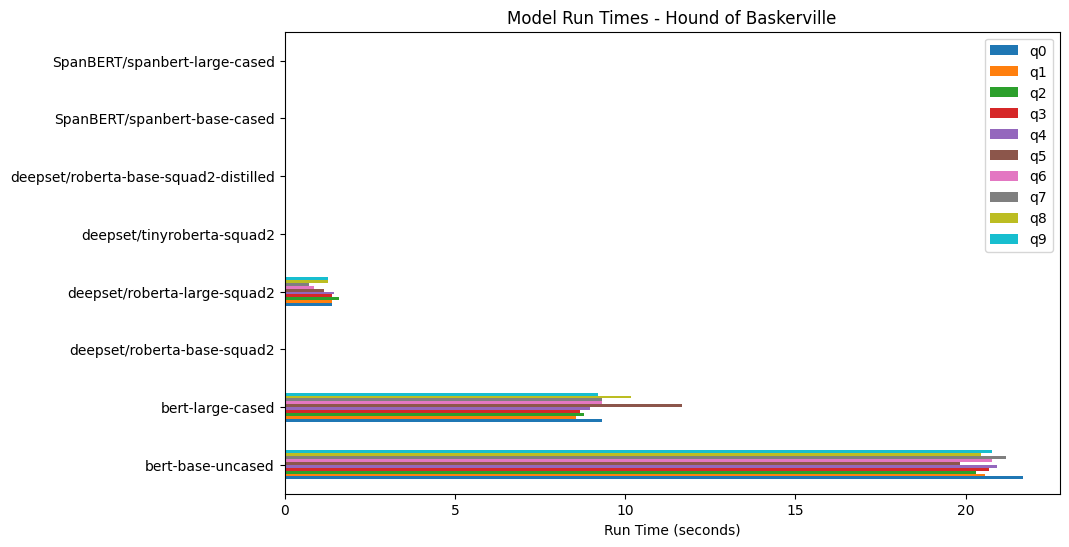

In [ ]:
FIGS = '/content/drive/Shareddrives/Team 2 - COSC524/Final Project/Final Code and Results/Graphs/'
df = pd.DataFrame(hound_run_times)
fig1 = df.plot(kind='barh', figsize=(10, 6), title='Model Run Times - Hound of Baskerville', xlabel='Run Time (seconds)')
fig1.get_figure().savefig(f'{FIGS}/hound_run_times.png')

In [ ]:
df

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,21.672152,20.577602,20.315377,20.676634,20.923046,19.821282,20.758187,21.184299,20.443529,20.774796
bert-large-cased,9.305754,8.570689,8.792134,8.671602,8.961998,11.666398,9.324686,9.329827,10.168714,9.205258
deepset/roberta-base-squad2,0.000004,0.000005,0.000007,0.000005,0.000005,0.000005,0.000005,0.000005,0.000006,0.000005
deepset/roberta-large-squad2,1.386176,1.380481,1.602500,1.379251,1.439554,1.167353,0.855357,0.713418,1.277710,1.277642
deepset/tinyroberta-squad2,0.000006,0.000005,0.000005,0.000005,0.000004,0.000005,0.000005,0.000005,0.000005,0.000006
deepset/roberta-base-squad2-distilled,0.000003,0.000003,0.000002,0.000002,0.000002,0.000003,0.000003,0.000003,0.000003,0.000002
SpanBERT/spanbert-base-cased,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000002,0.000002,0.000002
SpanBERT/spanbert-large-cased,0.000003,0.000002,0.000003,0.000002,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002


In [ ]:
pd.DataFrame(valley_responses)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,"candle hand. tall, lean figure inclined",Douglas,Douglas,Douglas,Douglas,"candle hand. tall, lean figure inclined","Wilson pointed out, triggers wired together th...","Ettie, let","Ettie, let","reign James I, standing upon"
bert-large-cased,"Curious, because, far one","dumb-bells,” said Ames. “Dumb-bell—","dumb-bells,” said Ames. “Dumb-bell—","dumb-bells,” said Ames. “Dumb-bell—","dumb-bells,” said Ames. “Dumb-bell—",you’,"dumb-bells,” said Ames. “Dumb-bell—","Curious, because, far one",you’,you’
deepset/roberta-base-squad2,McMurdo,Birdy Edwards,McMurdo,Chicago,shotgun,enough,hounds trail,Mediocrity,painting Jean Baptiste Greuze,Birdy Edwards
deepset/roberta-large-squad2,White Mason,John Douglas,McMurdo,Tunbridge Wells,’,’,’,proficiency,By Gar,Ted Baldwin
deepset/tinyroberta-squad2,McMurdo,Mr. Holmes,McMurdo,Chicago,shotgun,last night,flattened paper upon unused plate,witchcraft,flattened paper upon unused plate,twitching bushy eyebrows
deepset/roberta-base-squad2-distilled,Inspector MacDonald,Mrs. Douglas,McMurdo,Union House,shotgun,Maybe places,hounds trail,Perhaps heard shot,“Because fell talk him,Birdy Edwards
SpanBERT/spanbert-base-cased,room,room,room,room,room,safe snug sheltering,room,room,norter.” “Your friend seems,Chicago went changed name
SpanBERT/spanbert-large-cased,"Holmes?” friend sat head upon hands, sunk deepest","ain’t it? Well, death came uncommon handy you,...",shut. I’ll get lodge,"t it? Well, death came uncommon handy you, would","t it? Well, death came uncommon handy you, would","“Spare money,” said dead, even tone. “","then, driven back","t it? Well, death came uncommon handy you, would","Holmes?” friend sat head upon hands, sunk deepest","Holmes.” “Then, permission, leave that"


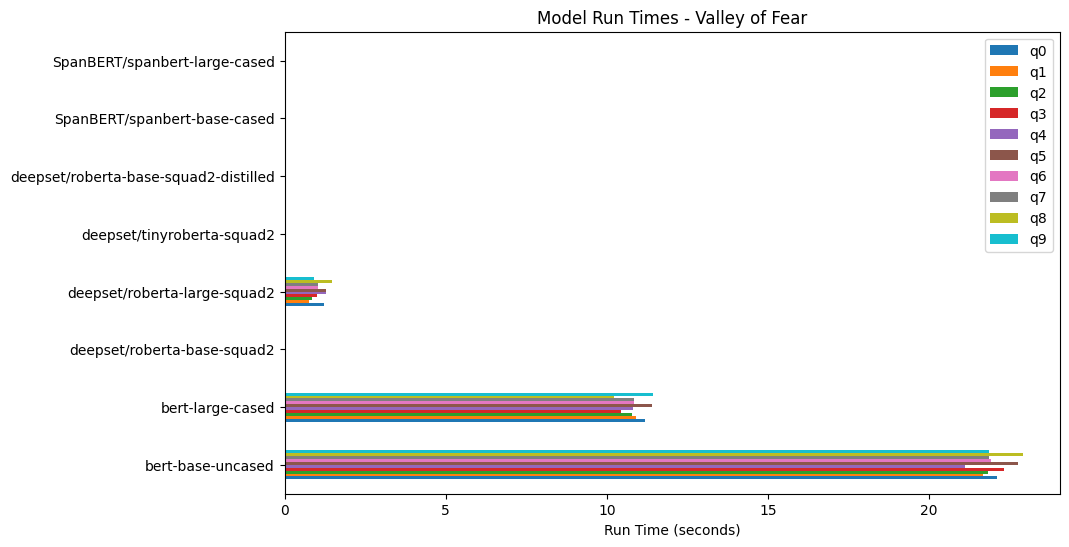

In [ ]:
df2 = pd.DataFrame(valley_run_times)
fig2 = df2.plot(kind='barh', figsize=(10, 6), title='Model Run Times - Valley of Fear', xlabel='Run Time (seconds)')
fig2.get_figure().savefig(f'{FIGS}/valley_run_times.png')

In [ ]:
df2

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,22.112489,21.658643,21.828624,22.316843,21.116568,22.758996,21.914621,21.847105,22.904118,21.863475
bert-large-cased,11.177787,10.917757,10.772586,10.451562,10.803663,11.409745,10.842553,10.841725,10.228663,11.438913
deepset/roberta-base-squad2,0.000005,0.000005,0.000005,0.000006,0.000005,0.000005,0.000005,0.000005,0.000005,0.000006
deepset/roberta-large-squad2,1.227865,0.761333,0.851425,1.009541,1.278315,1.289150,1.045573,1.037086,1.464981,0.900246
deepset/tinyroberta-squad2,0.000005,0.000005,0.000005,0.000006,0.000005,0.000005,0.000004,0.000005,0.000005,0.000004
deepset/roberta-base-squad2-distilled,0.000003,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002,0.000003,0.000003,0.000002
SpanBERT/spanbert-base-cased,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
SpanBERT/spanbert-large-cased,0.000002,0.000002,0.000003,0.000002,0.000002,0.037183,0.000002,0.000002,0.000002,0.000002


In [ ]:
pd.DataFrame(scarlet_responses)

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,221B,221B,221B,221B,221B,221B,221B,221B,221B,221B
bert-large-cased,dull,dull,dull,dull,dull,"odd pounds it, nothing taken. Whatever motives",dull,dull,"century lawyer, suppose. writing legal twist i...",dull
deepset/roberta-base-squad2,Lestrade,Drebber,Drebber,Salt Lake City,rifle,Echo_ day,drunk sort o’ man,writer going put female name Rachel,sharp needles,"that fool Lestrade, thinks smart, gone upon wr..."
deepset/roberta-large-squad2,Lestrade,Lucy Ferrier,Brigham Young,Brixton Road,knife,’,’,robbery,Brigham Young,Brigham Young
deepset/tinyroberta-squad2,Lestrade,Joseph Stangerson,Sherlock Holmes,Scotland Yard,rifle,hunter’,wound upon dead man’s person,despotism hatred Liberalism,dark plain sky,thickens
deepset/roberta-base-squad2-distilled,Jefferson Hope,father,Drebber,Brixton Road,rifle,mountains,Sherlock Holmes yet finished breakfast,Brigham Young,Knowledge Literature,Sherlock Holmes
SpanBERT/spanbert-base-cased,"Latin character, may",see that?” cried. “It seems knows deal should.,"Latin character, may","Latin character, may",see that?” cried. “It seems knows deal should.,mantelpiece—a red wax one—and light saw,gloomy,see that?” cried. “It seems knows deal should.,"Latin character, may","Latin character, may"
SpanBERT/spanbert-large-cased,"Again, absurd suppose sane man would carry del...",shall see me.” tore,shall see me.” tore,shall see me.” tore,"Again, absurd suppose sane man would carry del...",second man to-day used,second man to-day used,"Again, absurd suppose sane man would carry del...",intended kill cold blood. would rigid justice ...,"Again, absurd suppose sane man would carry del..."


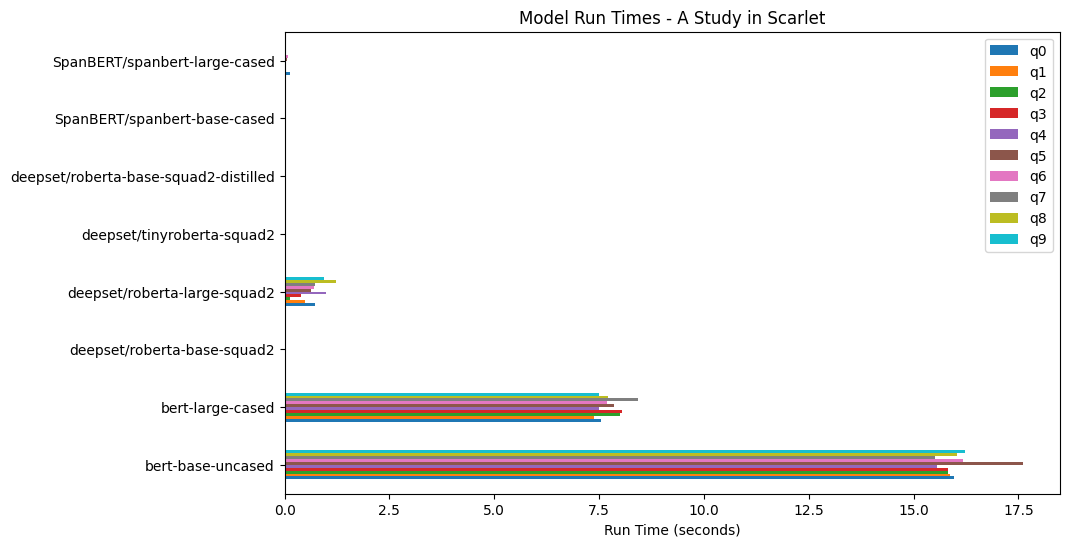

In [ ]:
df3 = pd.DataFrame(scarlet_run_times)
fig3 = df3.plot(kind='barh', figsize=(10, 6), title='Model Run Times - A Study in Scarlet', xlabel='Run Time (seconds)')
fig3.get_figure().savefig(f'{FIGS}/scarlet_run_times.png')

In [ ]:
df3

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9
bert-base-uncased,15.969301,15.876504,15.827019,15.814537,15.555679,17.600978,16.168744,15.506124,16.044573,16.218154
bert-large-cased,7.555115,7.385672,8.007101,8.053026,7.503401,7.853205,7.681027,8.439277,7.721981,7.486866
deepset/roberta-base-squad2,0.000003,0.000005,0.000004,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000007
deepset/roberta-large-squad2,0.732252,0.494812,0.121814,0.395836,0.978822,0.634601,0.706640,0.720403,1.224701,0.940522
deepset/tinyroberta-squad2,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005
deepset/roberta-base-squad2-distilled,0.000002,0.000003,0.000002,0.000003,0.000003,0.000003,0.000002,0.000003,0.000003,0.000002
SpanBERT/spanbert-base-cased,0.000002,0.000003,0.000002,0.000002,0.000003,0.000002,0.000003,0.000002,0.000002,0.000002
SpanBERT/spanbert-large-cased,0.124978,0.000002,0.000003,0.000002,0.000003,0.062740,0.071470,0.000002,0.000002,0.000002
